In [1]:
# Essential imports for height-constrained humanoid training
from datetime import datetime
import functools
import time
import os
import subprocess

import jax
import numpy as np
import jax.numpy as jnp
from matplotlib import pyplot as plt
import wandb
import mujoco

from brax import envs
from brax.base import State as PipelineState
from brax.envs.base import Env, PipelineEnv, State as BraxState
from brax.training.agents.ppo_lagrange_v2 import train as ppo_lagrange_v2
from brax.training.agents.ppo_lagrange_v3 import train as ppo_lagrange_v3
from brax.training.agents.ppo import train as ppo
from brax.io import model as brax_model
from brax.io import json as brax_json

# GPU and MuJoCo validation
try:
    if subprocess.run('nvidia-smi', capture_output=True).returncode:
        print("Warning: Cannot communicate with GPU")
    else:
        print("✓ GPU detected")
except:
    print("Warning: nvidia-smi not available")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
os.environ['MUJOCO_GL'] = 'egl'

try:
    print('Checking MuJoCo installation...')
    mujoco.MjModel.from_xml_string('<mujoco/>')
    print('✓ MuJoCo installation successful')
except Exception as e:
    raise RuntimeError(f'MuJoCo installation failed: {e}')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

print("✓ Environment setup complete")


✓ GPU detected
Checking MuJoCo installation...
✓ MuJoCo installation successful
✓ Environment setup complete


In [2]:
# Configuration for height-constrained humanoid training

# Args class for cleaner configuration management
class Args:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

# Environment configuration
env_name = 'humanoid_height_constrained'

# Environment specific parameters
env_config = {
    'max_height': 1.0,  # Maximum allowed height (meters) - set well below standing height to force crawling
    'height_cost_weight': 1.0,  # Weight for height violation cost
    # Note: Uses HumanoidStandup as base for collision-enabled body parts (torso, arms, thighs)
    # This enables TRUE crawling behaviors, unlike regular Humanoid where only feet collide with ground
}

# Training configuration using Args class
args = Args(
    num_timesteps=10_000_000,
    num_evals=10,
    episode_length=1000,
    num_envs=2048,
    batch_size=512,
    learning_rate=3e-4,
    entropy_cost=1e-3,
    unroll_length=10,
    num_minibatches=32,
    num_updates_per_batch=8,
    discounting=0.99,
    normalize_observations=True,
    reward_scaling=1.0,
    action_repeat=1,
    seed=42,
    max_devices_per_host=None,
    # PPO Lagrange specific
    safety_bound=10,  # Maximum allowed height violation
    lagrangian_coef_rate=0.01,
    initial_lambda_lagr=0.0,
    # Training metrics logging
    log_training_metrics=True,
    training_metrics_steps=None,  # Will be set based on episode_length * num_envs / 5
)

# Calculate training metrics steps
if args.training_metrics_steps is None:
    args.training_metrics_steps = args.episode_length * args.num_envs // 5

# Weights & Biases configuration
config_dict_for_wandb = vars(args)
config_dict_for_wandb.update({
    "environment_name": env_name,
    "max_height": env_config['max_height'],
    "height_cost_weight": env_config['height_cost_weight'],
    "base_environment": "HumanoidStandup",  # Note: inherits from HumanoidStandup for collision support
})

run_name = f"{env_name}_ppo_lag_v2_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
wandb_config = {
    'project': 'height_constrained_humanoid',
    'name': run_name,
    'config': config_dict_for_wandb,
}

print(f"✓ Configuration loaded:")
print(f"  Environment: {env_name}")
print(f"  Max height: {env_config['max_height']} m")
print(f"  Safety bound: {args.safety_bound}")
print(f"  Training steps: {args.num_timesteps:,}")
print(f"  W&B project: {wandb_config['project']}")
print(f"  W&B run: {wandb_config['name']}")


✓ Configuration loaded:
  Environment: humanoid_height_constrained
  Max height: 1.0 m
  Safety bound: 10
  Training steps: 10,000,000
  W&B project: height_constrained_humanoid
  W&B run: humanoid_height_constrained_ppo_lag_v2_20250906_033241


In [3]:
# Create training and evaluation environments
print("Creating environments...")

# Create environments directly - no wrapper needed
# The humanoid_height_constrained environment handles cost properly in state.info
train_env = envs.get_environment(env_name, **env_config)
eval_env = envs.get_environment(env_name, **env_config)

print(f"✓ Environment '{env_name}' created:")
print(f"  Max height: {env_config['max_height']} m")
print(f"  Action space: {train_env.action_size}")
print(f"  Observation space: {train_env.observation_size}")
print(f"  Cost handling: Built-in to environment (state.info['cost'])")


Creating environments...


/home/mrdbstn/school/safe-brax/safe-brax/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


✓ Environment 'humanoid_height_constrained' created:
  Max height: 1.0 m
  Action space: 17
  Observation space: 244
  Cost handling: Built-in to environment (state.info['cost'])


In [4]:
# Enhanced training progress function for height-constrained humanoid
training_metrics = []

def custom_progress_fn(num_steps, metrics, metrics_list=None, use_wandb=True):
    """
    Enhanced progress function to print metrics and log to Weights & Biases.
    Metrics dict can come from Brax's EpisodeMetricsLogger (keys like 'episode/reward')
    or from Evaluator (keys like 'eval/episode_reward').
    """
    print(f"Step {num_steps:,}:")
    wandb_log_data = {}
    
    # Key performance metrics
    perf_metrics = [
        'eval/episode_reward', 'eval/episode_forward_reward', 
        'episode/reward', 'episode/forward_reward'
    ]
    for key in perf_metrics:
        if key in metrics:
            value = metrics[key].item() if hasattr(metrics[key], 'item') else metrics[key]
            print(f"  {key.replace('eval/', '').replace('episode/', '')}: {value:.2f}")
    
    # Safety constraint metrics - print these prominently
    constraint_metrics = [
        'eval/episode_cost', 'eval/episode_height_cost', 'episode/cost',
        'training/lambda_lagr', 'training/cost_violation', 'training/mean_cost',
        'eval/episode_height', 'eval/episode_height_violation'
    ]
    for key in constraint_metrics:
        if key in metrics:
            value = metrics[key].item() if hasattr(metrics[key], 'item') else metrics[key]
            if "lambda" in key or "cost" in key or "constraint" in key or "height" in key:
                if "lambda" in key:
                    print(f"  {key}: {value:.6f}")
                elif "height" in key and "violation" not in key:
                    print(f"  {key}: {value:.2f} m")
                else:
                    print(f"  {key}: {value:.4f}")
    
    # Process all metrics for W&B logging
    for key, value in metrics.items():
        log_value = value.item() if hasattr(value, 'item') else value
        
        # Categorize metrics for better organization in W&B
        if not (key.startswith("episode/") or key.startswith("eval/") or key.startswith("training/")):
            wandb_log_data[f"training_batch/{key}"] = log_value
        else:
            wandb_log_data[key] = log_value

    # Log to W&B
    if use_wandb and wandb.run is not None and wandb_log_data:
        wandb.log(wandb_log_data, step=int(num_steps))

    # Store metrics locally for plotting
    if metrics_list is not None:
        metrics_data_local = {'step': num_steps}
        metrics_data_local.update(metrics)
        metrics_list.append(metrics_data_local)
    
    print()  # Empty line for readability

# Bound progress function for training
bound_progress_fn = functools.partial(
    custom_progress_fn, 
    metrics_list=training_metrics, 
    use_wandb=True
)

print("✓ Enhanced progress callback configured with W&B logging")
print("✓ Environment directly provides cost in state.info - no wrapper needed")


✓ Enhanced progress callback configured with W&B logging
✓ Environment directly provides cost in state.info - no wrapper needed


In [ ]:
# Initialize Weights & Biases and start training
print("Initializing Weights & Biases...")
wandb_run = wandb.init(
    project=wandb_config['project'],
    name=wandb_config['name'],
    config=wandb_config['config'],
    reinit=True
)
print(f"✓ W&B run initialized: {wandb_run.name}")

# Configure and start training
print("Starting PPO Lagrange v2 training...")
start_time = time.time()

# Setup the PPO training function using Args class
train_fn = functools.partial(
    ppo_lagrange_v3,
    num_timesteps=args.num_timesteps,
    num_evals=args.num_evals,
    reward_scaling=args.reward_scaling,
    episode_length=args.episode_length,
    normalize_observations=args.normalize_observations,
    action_repeat=args.action_repeat,
    unroll_length=args.unroll_length,
    num_minibatches=args.num_minibatches,
    num_updates_per_batch=args.num_updates_per_batch,
    learning_rate=args.learning_rate,
    entropy_cost=args.entropy_cost,
    discounting=args.discounting,
    num_envs=args.num_envs,
    batch_size=args.batch_size,
    max_devices_per_host=args.max_devices_per_host,
    seed=args.seed,
    # Enable Brax's internal episode metrics logging
    log_training_metrics=args.log_training_metrics,
    training_metrics_steps=args.training_metrics_steps,
    # PPO-Lagrange specific parameters
    safety_bound=args.safety_bound,
    lagrangian_coef_rate=args.lagrangian_coef_rate,
    initial_lambda_lagr=args.initial_lambda_lagr,
)

print("✓ Training function configured with enhanced parameters")

# Train the model
make_inference_fn, params, final_metrics = train_fn(
    environment=train_env,
    eval_env=eval_env,
    progress_fn=bound_progress_fn
)

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.1f} seconds")
print(f"Final metrics: {final_metrics}")

# Log final metrics to W&B
if final_metrics and wandb.run is not None:
    final_wandb_metrics = {}
    for key, value in final_metrics.items():
        if isinstance(value, (int, float, np.number)):
            final_wandb_metrics[f"final/{key}"] = float(value)
    
    # Add training summary
    final_wandb_metrics.update({
        'final/training_time_seconds': training_time,
        'final/training_steps': args.num_timesteps,
        'final/max_height_limit': env_config['max_height'],
        'final/safety_bound': args.safety_bound,
        'final/lagrangian_coef_rate': args.lagrangian_coef_rate,
    })
    
    wandb.log(final_wandb_metrics, step=args.num_timesteps)
    print("✓ Final metrics logged to W&B")


Initializing Weights & Biases...


wandb: Currently logged in as: m-boustani (m-boustani-eindhoven-university-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


✓ W&B run initialized: humanoid_height_constrained_ppo_lag_v2_20250906_033241
Starting PPO Lagrange v2 training...
✓ Training function configured with enhanced parameters
Step 0:
  episode_reward: 979.02
  episode_forward_reward: 0.73
  eval/episode_cost: 16883.8535
  eval/episode_height_cost: 16883.85 m
  eval/episode_height: 99.29 m
  eval/episode_height_violation: 1350.7083

Step 491,520:

Step 983,040:

Step 1,146,880:
  episode_reward: 957.74
  episode_forward_reward: -33.79
  eval/episode_cost: 16840.4766
  eval/episode_height_cost: 16840.48 m
  training/lambda_lagr: 0.276455
  training/cost_violation: 6.9315
  training/mean_cost: 16.9315
  eval/episode_height: 102.76 m
  eval/episode_height_violation: 1347.2382

Step 1,474,560:

Step 1,966,080:

Step 2,293,760:
  episode_reward: 980.24
  episode_forward_reward: -11.25
  eval/episode_cost: 16550.3574
  eval/episode_height_cost: 16550.36 m
  training/lambda_lagr: 0.754374
  training/cost_violation: 6.6607
  training/mean_cost: 16.

wandb: WARNING Tried to log to step 10000000 that is less than the current step 10321920. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


In [6]:
# Save trained model
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)

model_path = f'{model_dir}/humanoid_height_constrained_{timestamp}'
brax_model.save_params(model_path, params)
print(f"Model saved to: {model_path}")


Model saved to: models/humanoid_height_constrained_20250906_035536


In [7]:
# Evaluation rollout
print("Running evaluation rollout...")

rollout_env = envs.get_environment(env_name, **env_config)
rollout_steps = 2000

# Create inference function
inference_fn = make_inference_fn(params)
jit_inference_fn = jax.jit(inference_fn)
jit_reset = jax.jit(rollout_env.reset)
jit_step = jax.jit(rollout_env.step)

# Initialize rollout
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)

# Collect rollout data
rollout_data = {
    'rewards': [],
    'costs': [],
    'heights': [],
    'height_violations': [],
    'x_positions': [],
    'y_positions': [],
    'forward_rewards': [],
}

trajectory_states = []

for step in range(rollout_steps):
    # Get action from policy
    rng, act_rng = jax.random.split(rng)
    action, _ = jit_inference_fn(state.obs, act_rng)
    
    # Step environment
    state = jit_step(state, action)
    trajectory_states.append(state.pipeline_state)
    
    # Collect metrics
    rollout_data['rewards'].append(float(state.reward))
    rollout_data['costs'].append(float(state.metrics.get('cost', 0)))
    rollout_data['heights'].append(float(state.metrics.get('height', 0)))
    rollout_data['height_violations'].append(float(state.metrics.get('height_violation', 0)))
    rollout_data['x_positions'].append(float(state.metrics.get('x_position', 0)))
    rollout_data['y_positions'].append(float(state.metrics.get('y_position', 0)))
    rollout_data['forward_rewards'].append(float(state.metrics.get('forward_reward', 0)))
    
    if step % 500 == 0:
        print(f"Rollout step {step}/{rollout_steps}")
    
    if state.done:
        print(f"Episode terminated at step {step}")
        break

print(f"Rollout completed with {len(rollout_data['rewards'])} steps")

# Summary statistics
total_reward = sum(rollout_data['rewards'])
total_cost = sum(rollout_data['costs'])
max_height = max(rollout_data['heights'])
avg_height = np.mean(rollout_data['heights'])
total_violations = sum(rollout_data['height_violations'])

print(f"\nRollout Summary:")
print(f"  Total reward: {total_reward:.2f}")
print(f"  Total cost: {total_cost:.3f}")
print(f"  Max height: {max_height:.2f} m (limit: {env_config['max_height']} m)")
print(f"  Average height: {avg_height:.2f} m")
print(f"  Total height violations: {total_violations:.3f}")


Running evaluation rollout...


/home/mrdbstn/school/safe-brax/safe-brax/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


Rollout step 0/2000
Rollout step 500/2000
Rollout step 1000/2000
Rollout step 1500/2000
Rollout completed with 2000 steps

Rollout Summary:
  Total reward: 2034.55
  Total cost: 31454.158
  Max height: 0.38 m (limit: 1.0 m)
  Average height: 0.19 m
  Total height violations: 2516.333


In [8]:
# Save trajectory
trajectory_dir = 'trajectories'
os.makedirs(trajectory_dir, exist_ok=True)

trajectory_path = f'{trajectory_dir}/humanoid_height_constrained_rollout_{timestamp}.json'
brax_json.save(trajectory_path, rollout_env.sys, trajectory_states)
print(f"Trajectory saved to: {trajectory_path}")


Trajectory saved to: trajectories/humanoid_height_constrained_rollout_20250906_035536.json


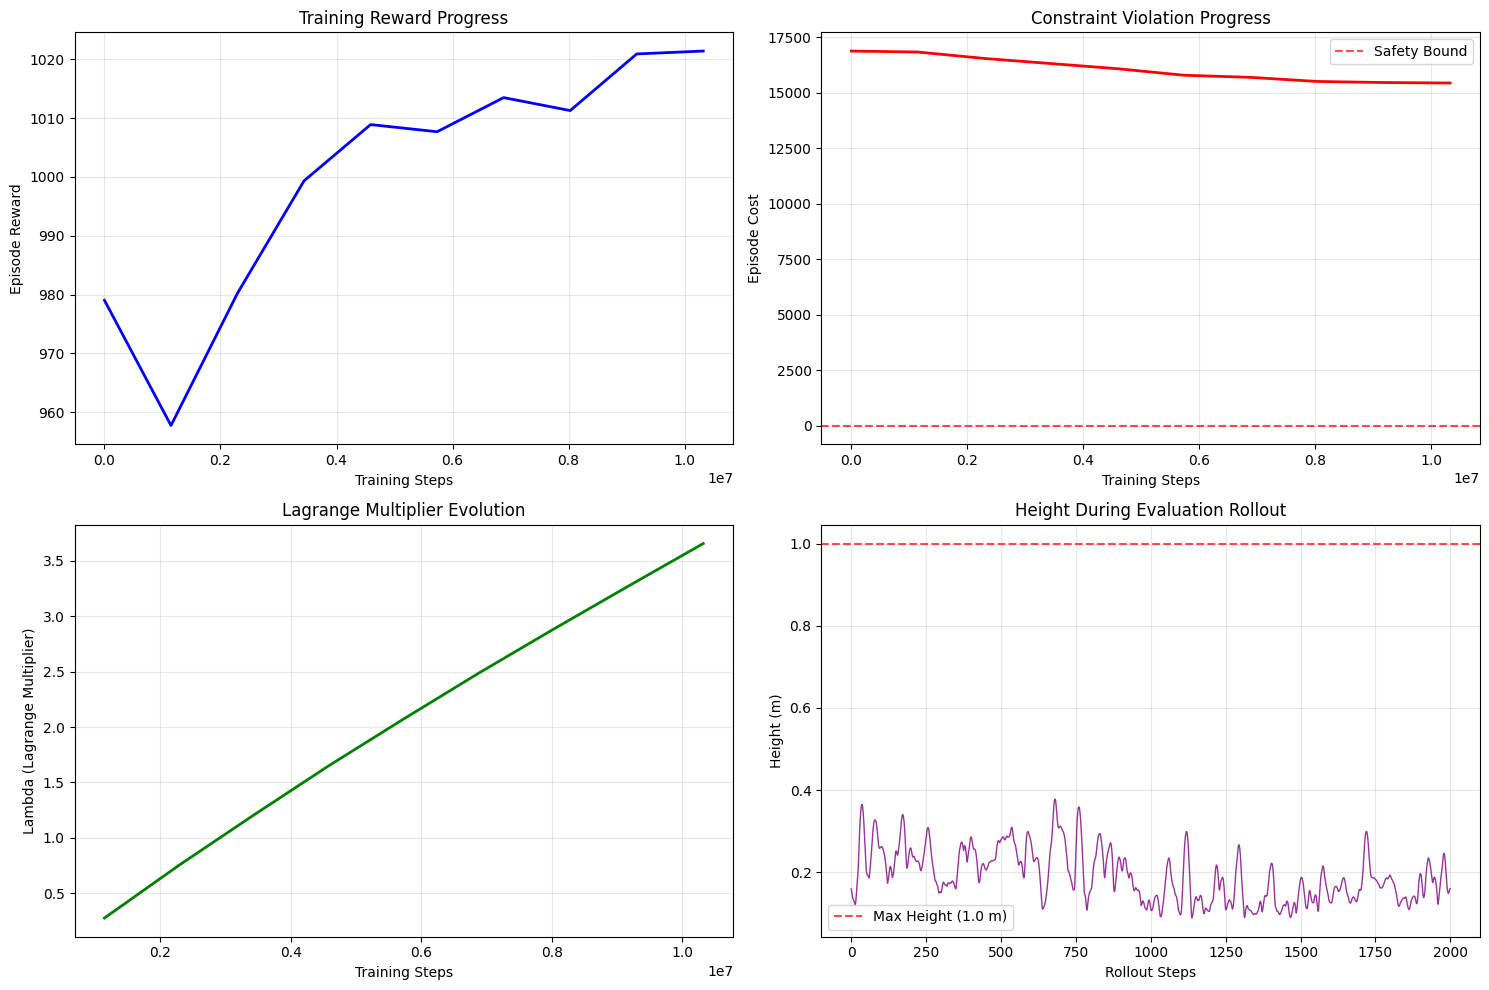

Training plots saved to: plots/humanoid_height_constrained_training_20250906_035536.png


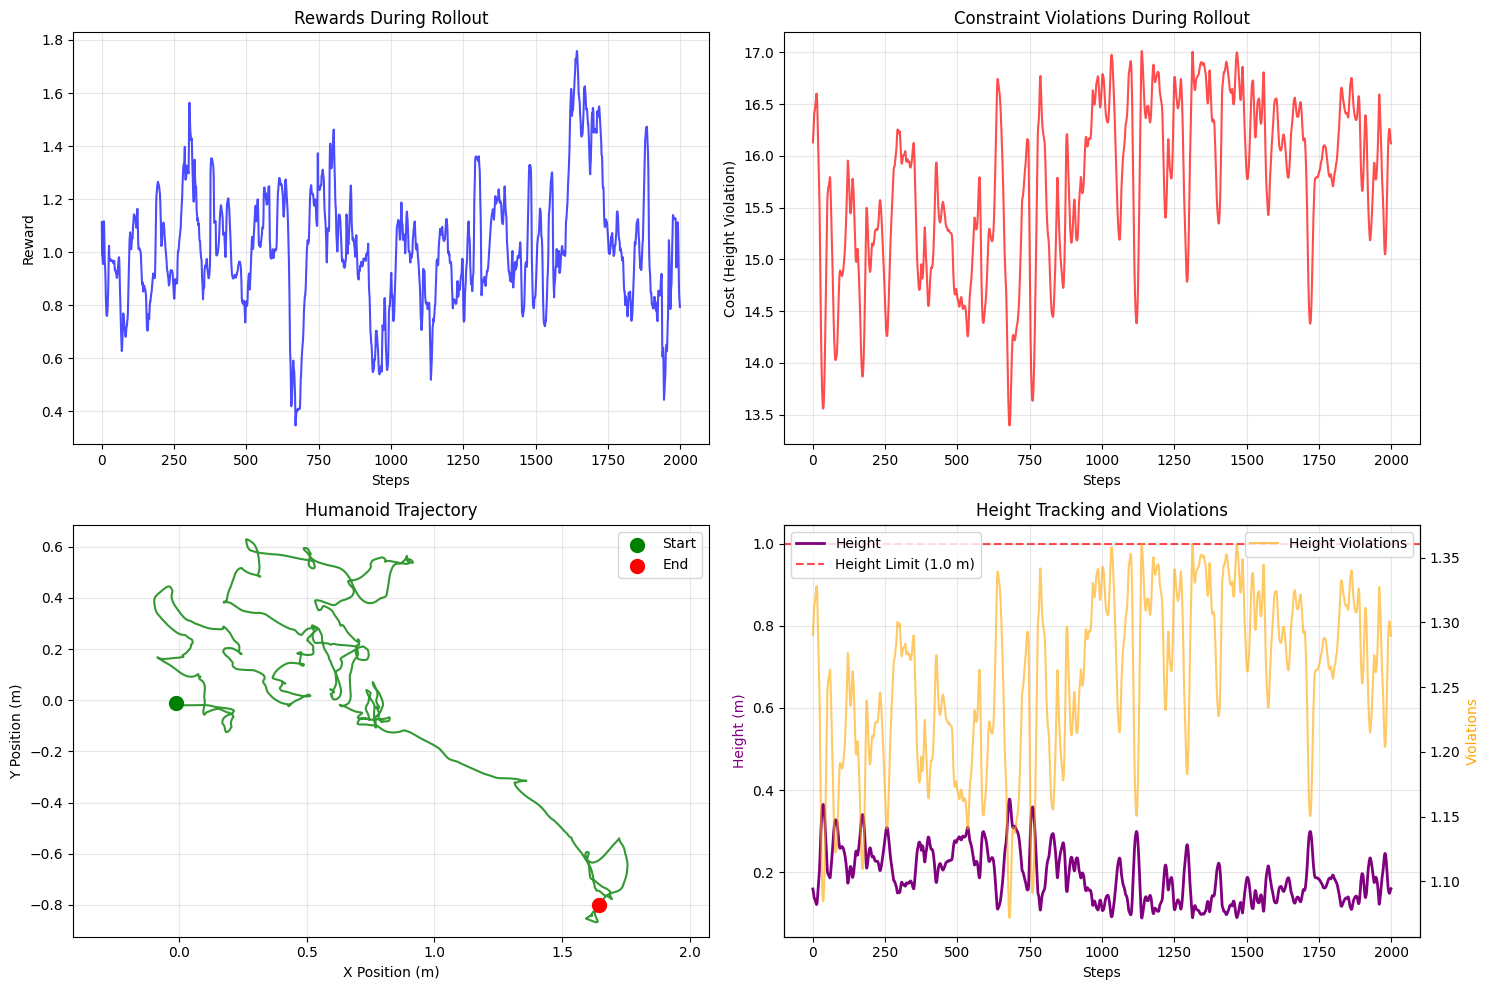

Rollout plots saved to: plots/humanoid_height_constrained_rollout_20250906_035536.png


In [9]:
# Generate plots
plt.style.use('default')
plot_dir = 'plots'
os.makedirs(plot_dir, exist_ok=True)

# Training progress plots
if training_metrics:
    steps = [m['step'] for m in training_metrics if 'eval/episode_reward' in m]
    rewards = [m['eval/episode_reward'] for m in training_metrics if 'eval/episode_reward' in m]
    costs = [m.get('eval/episode_cost', 0) for m in training_metrics if 'eval/episode_reward' in m]
    lambdas = [m.get('training/lambda_lagr', 0) for m in training_metrics if 'training/lambda_lagr' in m]
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Reward progress
    ax1.plot(steps, rewards, 'b-', linewidth=2)
    ax1.set_xlabel('Training Steps')
    ax1.set_ylabel('Episode Reward')
    ax1.set_title('Training Reward Progress')
    ax1.grid(True, alpha=0.3)
    
    # Cost progress
    ax2.plot(steps, costs, 'r-', linewidth=2)
    ax2.axhline(y=args.safety_bound, color='r', linestyle='--', alpha=0.7, label='Safety Bound')
    ax2.set_xlabel('Training Steps')
    ax2.set_ylabel('Episode Cost')
    ax2.set_title('Constraint Violation Progress')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Lambda evolution
    if lambdas:
        lambda_steps = [m['step'] for m in training_metrics if 'training/lambda_lagr' in m]
        ax3.plot(lambda_steps, lambdas, 'g-', linewidth=2)
        ax3.set_xlabel('Training Steps')
        ax3.set_ylabel('Lambda (Lagrange Multiplier)')
        ax3.set_title('Lagrange Multiplier Evolution')
        ax3.grid(True, alpha=0.3)
    
    # Height during rollout
    rollout_steps_plot = range(len(rollout_data['heights']))
    ax4.plot(rollout_steps_plot, rollout_data['heights'], 'purple', linewidth=1, alpha=0.8)
    ax4.axhline(y=env_config['max_height'], color='r', linestyle='--', alpha=0.7, label=f'Max Height ({env_config["max_height"]} m)')
    ax4.set_xlabel('Rollout Steps')
    ax4.set_ylabel('Height (m)')
    ax4.set_title('Height During Evaluation Rollout')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    training_plot_path = f'{plot_dir}/humanoid_height_constrained_training_{timestamp}.png'
    plt.savefig(training_plot_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Training plots saved to: {training_plot_path}")

# Rollout analysis plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
steps_rollout = range(len(rollout_data['rewards']))

# Rewards over time
ax1.plot(steps_rollout, rollout_data['rewards'], 'b-', alpha=0.7)
ax1.set_xlabel('Steps')
ax1.set_ylabel('Reward')
ax1.set_title('Rewards During Rollout')
ax1.grid(True, alpha=0.3)

# Costs over time
ax2.plot(steps_rollout, rollout_data['costs'], 'r-', alpha=0.7)
ax2.set_xlabel('Steps')
ax2.set_ylabel('Cost (Height Violation)')
ax2.set_title('Constraint Violations During Rollout')
ax2.grid(True, alpha=0.3)

# Trajectory (X-Y position)
ax3.plot(rollout_data['x_positions'], rollout_data['y_positions'], 'g-', alpha=0.8)
ax3.scatter(rollout_data['x_positions'][0], rollout_data['y_positions'][0], c='green', s=100, label='Start', zorder=5)
ax3.scatter(rollout_data['x_positions'][-1], rollout_data['y_positions'][-1], c='red', s=100, label='End', zorder=5)
ax3.set_xlabel('X Position (m)')
ax3.set_ylabel('Y Position (m)')
ax3.set_title('Humanoid Trajectory')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.axis('equal')

# Height vs violations
ax4.plot(steps_rollout, rollout_data['heights'], 'purple', label='Height', linewidth=2)
ax4.axhline(y=env_config['max_height'], color='r', linestyle='--', alpha=0.7, label=f'Height Limit ({env_config["max_height"]} m)')
ax4_twin = ax4.twinx()
ax4_twin.plot(steps_rollout, rollout_data['height_violations'], 'orange', alpha=0.6, label='Height Violations')
ax4.set_xlabel('Steps')
ax4.set_ylabel('Height (m)', color='purple')
ax4_twin.set_ylabel('Violations', color='orange')
ax4.set_title('Height Tracking and Violations')
ax4.legend(loc='upper left')
ax4_twin.legend(loc='upper right')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
rollout_plot_path = f'{plot_dir}/humanoid_height_constrained_rollout_{timestamp}.png'
plt.savefig(rollout_plot_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"Rollout plots saved to: {rollout_plot_path}")


In [10]:
# Final summary
print("\n" + "="*60)
print("HEIGHT-CONSTRAINED HUMANOID TRAINING SUMMARY")
print("="*60)
print(f"Environment: {env_name}")
print(f"Training steps: {args.num_timesteps:,}")
print(f"Training time: {training_time:.1f} seconds")
print(f"Height constraint: {env_config['max_height']} m")
print(f"Safety bound: {args.safety_bound}")
print(f"Lagrangian coef rate: {args.lagrangian_coef_rate}")
if 'wandb_run' in locals() and wandb_run is not None:
    print(f"W&B project: {wandb_config['project']}")
    print(f"W&B run: {wandb_run.name}")
    print(f"W&B url: {wandb_run.url}")
print()
print("FINAL PERFORMANCE:")
if final_metrics:
    for key, value in final_metrics.items():
        if isinstance(value, (int, float, np.number)):
            log_value = value.item() if hasattr(value, 'item') else value
            print(f"  {key}: {log_value:.4f}")
print()
print("ROLLOUT ANALYSIS:")
print(f"  Total reward: {total_reward:.2f}")
print(f"  Total cost: {total_cost:.3f}")
print(f"  Max height: {max_height:.2f} m (limit: {env_config['max_height']} m)")
print(f"  Average height: {avg_height:.2f} m")
print(f"  Constraint violations: {total_violations:.3f}")
print(f"  Distance traveled: {rollout_data['x_positions'][-1]:.2f} m")
print(f"  Steps completed: {len(rollout_data['rewards'])}")
print()
print("FILES & ARTIFACTS:")
print(f"  Model: {model_path}")
print(f"  Trajectory: {trajectory_path}")
if 'training_plot_path' in locals():
    print(f"  Training plots: {training_plot_path}")
if 'rollout_plot_path' in locals():
    print(f"  Rollout plots: {rollout_plot_path}")
print()
print("TRAINING CONFIGURATION:")
print(f"  Cost handling: Built-in to environment (no wrapper needed)")
print(f"  PPO Lagrange v2: Enhanced with training metrics logging")
print(f"  Episodes logged: {args.training_metrics_steps} steps interval")
print(f"  Environment: Direct cost in state.info for PPO Lagrange v2")
print("="*60)



HEIGHT-CONSTRAINED HUMANOID TRAINING SUMMARY
Environment: humanoid_height_constrained
Training steps: 10,000,000
Training time: 1339.9 seconds
Height constraint: 1.0 m
Safety bound: 10
Lagrangian coef rate: 0.01
W&B project: height_constrained_humanoid
W&B run: humanoid_height_constrained_ppo_lag_v2_20250906_033241
W&B url: https://wandb.ai/m-boustani-eindhoven-university-of-technology/height_constrained_humanoid/runs/p8afck7a

FINAL PERFORMANCE:
  eval/walltime: 287.6065
  training/sps: 10109.3820
  training/walltime: 1028.6476
  eval/epoch_eval_time: 22.1489
  eval/sps: 5779.0561

ROLLOUT ANALYSIS:
  Total reward: 2034.55
  Total cost: 31454.158
  Max height: 0.38 m (limit: 1.0 m)
  Average height: 0.19 m
  Constraint violations: 2516.333
  Distance traveled: 1.65 m
  Steps completed: 2000

FILES & ARTIFACTS:
  Model: models/humanoid_height_constrained_20250906_035536
  Trajectory: trajectories/humanoid_height_constrained_rollout_20250906_035536.json
  Training plots: plots/humanoid

In [11]:
# Finish W&B run
if wandb.run is not None:
    # Log rollout summary to W&B
    rollout_summary = {
        'rollout/total_reward': total_reward,
        'rollout/total_cost': total_cost,
        'rollout/max_height': max_height,
        'rollout/avg_height': avg_height,
        'rollout/total_violations': total_violations,
        'rollout/distance_traveled': rollout_data['x_positions'][-1],
        'rollout/steps_completed': len(rollout_data['rewards']),
    }
    wandb.log(rollout_summary, step=args.num_timesteps)
    
    # Upload plots to W&B
    if 'training_plot_path' in locals():
        wandb.log({"training_plots": wandb.Image(training_plot_path)})
    if 'rollout_plot_path' in locals():
        wandb.log({"rollout_plots": wandb.Image(rollout_plot_path)})
    
    print("Rollout metrics and plots uploaded to W&B")
    wandb.finish()
    print("W&B run finished")


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Rollout metrics and plots uploaded to W&B


episode/cost,████▆▆▆▆▃▃▃▃▂▂▂▂▁
episode/distance_from_origin,▂▂▂▂▁▁▁▁▃▃▃▃▆▆▆▆█
episode/forward_reward,▁▁▁▁▅▅▅▅▇▇▇▇▇▇▇▇█
episode/height,▁▁▁▁▃▃▃▃▆▆▆▆▇▇▇▇█
episode/height_cost,████▆▆▆▆▃▃▃▃▂▂▂▂▁
episode/height_violation,████▆▆▆▆▃▃▃▃▂▂▂▂▁
episode/length,████▁▁▁▁▁▁▁▁▁▁▁▁▁
episode/reward_linup,▁▁▁▁▅▅▅▅▇▇▇▇▇▇▇▇█
episode/reward_quadctrl,▇▇▇▇████▅▅▅▅▂▂▂▂▁
episode/sum_reward,▁▁▁▁▅▅▅▅▇▇▇▇▇▇▇▇█
episode/x_position,▁▁▁▁▆▆▆▆▇▇▇▇▇▇▇▇█


W&B run finished
